In [1]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, Model
import pathlib
from tensorflow.keras import Input
import numpy as np
from tensorflow.keras.layers import Lambda, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Concatenate
from tensorflow.keras.metrics import MeanIoU
import datetime
import matplotlib.pyplot as plt

In [2]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    image = tf.image.decode_png(image, channels = 3)
    mask = tf.image.decode_png(mask, channels = 1)/255
    return image, mask

In [20]:
def batch_data (path_X, path_y, batch_size):
    X_names = os.listdir(path_X)
    X_path = [f'{path_X}/{file}' for file in X_names]
    y_names = os.listdir(path_y)
    y_path = [f'{path_y}/{file}' for file in y_names]
    ds_train = tf.data.Dataset.from_tensor_slices((X_path, y_path))
    return ds_train.shuffle(buffer_size = len(X_path), seed = 10).map(process_path).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [21]:
def unet_model(img_height, img_width, channels):

    #Input
    inputs = Input((img_height, img_width, channels), name="input")
    normalisation = Lambda(lambda x: x / 255, name="normalisation")(inputs) #Normalize the pixels by dividing by 255

      
    convolution1 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(normalisation)
    convolution1 = BatchNormalization()(convolution1) 
    convolution1 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(convolution1)
    pooling1 = MaxPooling2D((2, 2))(convolution1)
    
    convolution2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(pooling1)
    convolution2 = BatchNormalization()(convolution2)
    convolution2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(convolution2)
    pooling2 = MaxPooling2D((2, 2))(convolution2)
     
    convolution3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pooling2)
    convolution3 = BatchNormalization()(convolution3)
    convolution3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(convolution3)
    pooling3 = MaxPooling2D((2, 2))(convolution3)
     
    convolution4 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pooling3)
    convolution4 = BatchNormalization()(convolution4)
    convolution4 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(convolution4)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convolution4)

    #Bottleneck at the base of the U-net 
    convolution5 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pooling4)
    convolution5 = BatchNormalization()(convolution5)
    convolution5 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(convolution5)
    
    #Decoder where we are indicating to the model the precise location of the features 
    transconv6 = Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution5)
    transconv6 = Concatenate()([transconv6, convolution4])
    convolution6 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(transconv6)
    convolution6 = BatchNormalization()(convolution6)
    convolution6 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(convolution6)
     
    transconv7 = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution6)
    transconv7 = Concatenate()([transconv7, convolution3])
    convolution7 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(transconv7)
    convolution7 = BatchNormalization()(convolution7)
    convolution7 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(convolution7)
     
    transconv8 = Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution7)
    transconv8 = Concatenate()([transconv8, convolution2])
    convolution8 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(transconv8)
    convolution8 = BatchNormalization()(convolution8)
    convolution8 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(convolution8)
     
    transconv9 = Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding='same')(convolution8)
    transconv9 = Concatenate()([transconv9, convolution1])
    convolution9 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(transconv9)
    convolution9 = BatchNormalization()(convolution9)
    convolution9 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(convolution9)
  
   
    
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(convolution9)
     
    model = Model(inputs=inputs, outputs=outputs)
    jaccard = MeanIoU(2)
    
    #loss options include: binary_crossentropy, IoU Loss (Jaccard Index), dice loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics="accuracy") 
    
#     model.summary()
    
    return model

In [22]:
channels=3
img_height = 256
img_width = 256

In [23]:
model = unet_model(img_height, img_width, channels)

In [24]:
path_X = '/home/zhlj/code/solar_panel_segmentation/tests/Small_dataset/Images'
path_y = '/home/zhlj/code/solar_panel_segmentation/tests/Small_dataset/Target'
batch_size = 8

In [25]:
# log data for tensorboard visualization
logs_dir = log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_dir , histogram_freq=1)

In [9]:
batches = batch_data(path_X,path_y,batch_size)

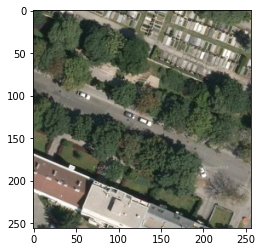

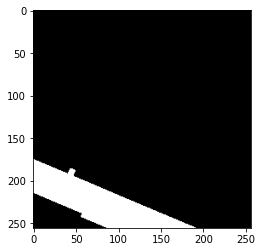

In [10]:
for image, mask in batches:
    plt.imshow(image[0])
    plt.show()
    plt.imshow(mask[0], cmap='gray')
    break

In [26]:
history = model.fit(batches, epochs=100, callbacks=[tb_callback])

Epoch 1/100
276/276 [==============================] - 44s 156ms/step - loss: 0.2519 - accuracy: 0.8945
Epoch 2/100
276/276 [==============================] - 43s 156ms/step - loss: 0.1847 - accuracy: 0.9293
Epoch 3/100
276/276 [==============================] - 43s 156ms/step - loss: 0.1709 - accuracy: 0.9350
Epoch 4/100
276/276 [==============================] - 43s 156ms/step - loss: 0.1629 - accuracy: 0.9377
Epoch 5/100
276/276 [==============================] - 43s 156ms/step - loss: 0.1550 - accuracy: 0.9404
Epoch 6/100
276/276 [==============================] - 43s 156ms/step - loss: 0.1494 - accuracy: 0.9430
Epoch 7/100
241/276 [=========================>....] - ETA: 5s - loss: 0.1411 - accuracy: 0.9465

2022-12-01 19:51:57.582015: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.00MiB (rounded to 67108864)requested by op gradient_tape/model_3/conv2d_35/Conv2D/Conv2DBackpropInput
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-01 19:51:57.582136: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-12-01 19:51:57.582151: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 301, Chunks in use: 301. 75.2KiB allocated for chunks. 75.2KiB in use in bin. 29.6KiB client-requested in use in bin.
2022-12-01 19:51:57.582157: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 68, Chunks in use: 66. 34.0KiB allocated for chunks. 33.0KiB in use in bin. 33.0KiB client-re

ResourceExhaustedError:  OOM when allocating tensor with shape[8,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_3/conv2d_35/Conv2D/Conv2DBackpropInput
 (defined at /home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_19538]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/model_3/conv2d_35/Conv2D/Conv2DBackpropInput:
In[0] gradient_tape/model_3/conv2d_35/Conv2D/ShapeN:	
In[1] model_3/conv2d_35/Conv2D/ReadVariableOp (defined at /home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/layers/convolutional.py:231)	
In[2] gradient_tape/model_3/conv2d_35/ReluGrad:

Operation defined at: (most recent call last)
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_4671/3913225678.py", line 1, in <module>
>>>     history = model.fit(batches, epochs=100, callbacks=[tb_callback])
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/home/zhlj/.pyenv/versions/3.8.12/envs/solar_panel/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

In [ ]:
model.layers

In [ ]:
model.summary()

In [ ]:
output1 = model.layers[1]
output1(tf.cast(image, 'float32'))

In [12]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input',
 'normalisation',
 'conv2d',
 'batch_normalization',
 'conv2d_1',
 'max_pooling2d',
 'conv2d_2',
 'batch_normalization_1',
 'conv2d_3',
 'max_pooling2d_1',
 'conv2d_4',
 'batch_normalization_2',
 'conv2d_5',
 'max_pooling2d_2',
 'conv2d_6',
 'batch_normalization_3',
 'conv2d_7',
 'max_pooling2d_3',
 'conv2d_8',
 'batch_normalization_4',
 'conv2d_9',
 'conv2d_transpose',
 'concatenate',
 'conv2d_10',
 'batch_normalization_5',
 'conv2d_11',
 'conv2d_transpose_1',
 'concatenate_1',
 'conv2d_12',
 'batch_normalization_6',
 'conv2d_13',
 'conv2d_transpose_2',
 'concatenate_2',
 'conv2d_14',
 'batch_normalization_7',
 'conv2d_15',
 'conv2d_transpose_3',
 'concatenate_3',
 'conv2d_16',
 'batch_normalization_8',
 'conv2d_17',
 'conv2d_18']

In [13]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'normalisation')>,
 <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 128, 128, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv2d_4')>,
 <

In [14]:
feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)


In [15]:
feature_map_model(tf.cast(image, 'float32'))

[<tf.Tensor: shape=(8, 256, 256, 3), dtype=float32, numpy=
 array([[[[ 52.,  69.,  50.],
          [ 50.,  67.,  48.],
          [ 42.,  59.,  40.],
          ...,
          [125., 110.,  89.],
          [131., 113.,  91.],
          [133., 111.,  90.]],
 
         [[ 49.,  66.,  47.],
          [ 52.,  69.,  50.],
          [ 45.,  62.,  43.],
          ...,
          [120., 108.,  86.],
          [123., 107.,  84.],
          [124., 103.,  82.]],
 
         [[ 53.,  70.,  51.],
          [ 62.,  79.,  60.],
          [ 59.,  76.,  57.],
          ...,
          [108., 100.,  77.],
          [124., 112.,  88.],
          [127., 111.,  88.]],
 
         ...,
 
         [[148., 146., 134.],
          [143., 141., 129.],
          [141., 139., 127.],
          ...,
          [140., 136., 124.],
          [140., 140., 130.],
          [134., 135., 127.]],
 
         [[152., 150., 138.],
          [150., 148., 136.],
          [149., 147., 135.],
          ...,
          [140., 138., 126.]

In [ ]:
plt.imshow(image[1])

In [ ]:
tmp_image = tf.expand_dims(image[1], axis = 0)

In [ ]:
tmp_image

In [ ]:
feature_maps[0].shape

In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")


In [17]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4: # Number of feature images/dimensions in a feature map of a layer 
        k = feature_map.shape[-1]  
        size=feature_map.shape[2]
        row = feature_map.shape[1]
        
        image_belt = np.array([[0]*k*size for i in range(row)])
        for i in range(k):
            feature_image = feature_map[0, :, :, i]  #first image of the batch for channel i
            feature_image-= feature_image.mean()
            feature_image/= feature_image.std ()
            feature_image*=  64
            feature_image+= 128
            feature_image= np.clip(feature_image, 0, 255)
            image_belt[:,i * size : (i + 1) * size] = feature_image
            
        scale = 20. / k
        plt.figure( figsize=(scale * k, scale) )
        plt.title ( layer_name )
        plt.grid  (False )
        plt.imshow(image_belt, aspect='auto')
        

NameError: name 'feature_maps' is not defined

In [18]:
def vis_cnn_feature_maps(model, image):
    """input model and image, this function will display images after go through each CNN layer"""
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers]
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    image = tf.expand_dims(image, axis=0)
    feature_maps = feature_map_model.predict(image)
    for layer_name, feature_map in zip(layer_names, feature_maps):
        if len(feature_map.shape) == 4: # Number of feature images/dimensions in a feature map of a layer 
            k = feature_map.shape[-1]  
            size=feature_map.shape[2]
            row = feature_map.shape[1]

            image_belt = np.array([[0]*k*size for i in range(row)])
            for i in range(k):
                feature_image = feature_map[0, :, :, i]  #first image of the batch for channel i
                feature_image -= feature_image.mean()
                feature_image /= feature_image.std()
                feature_image *=  64
                feature_image += 128
                feature_image = np.clip(feature_image, 0, 255)
                image_belt[:,i * size : (i + 1) * size] = feature_image

            scale = 20. / k
            plt.figure( figsize=(scale * k, scale) )
            plt.title ( layer_name )
            plt.grid  (False )
            plt.imshow(image_belt, aspect='auto')


/tmp/ipykernel_4671/1499037174.py:18: RuntimeWarning: invalid value encountered in divide
  feature_image /= feature_image.std()
/tmp/ipykernel_4671/1499037174.py:18: RuntimeWarning: divide by zero encountered in divide
  feature_image /= feature_image.std()
/tmp/ipykernel_4671/1499037174.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * k, scale) )


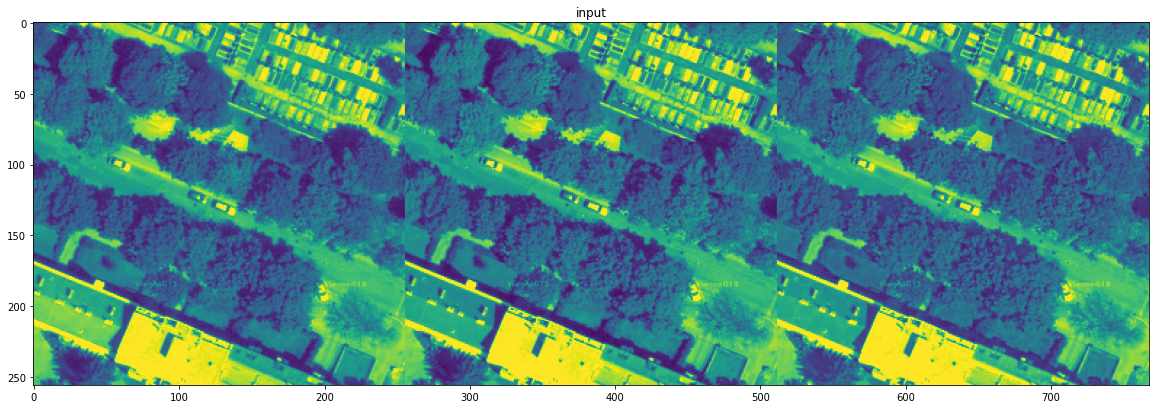

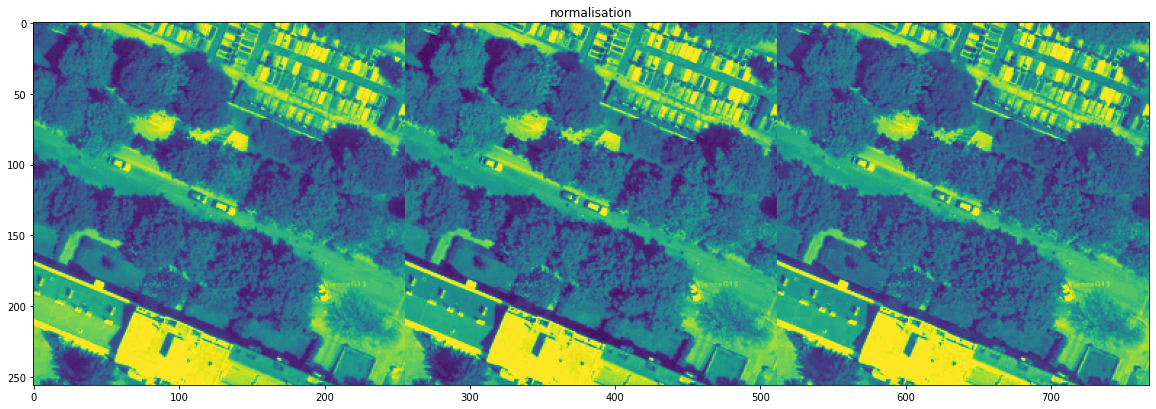

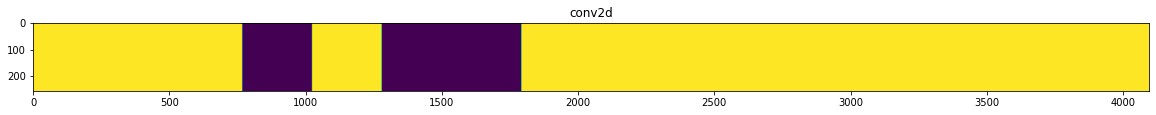

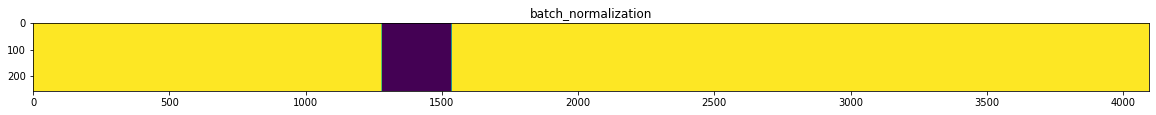

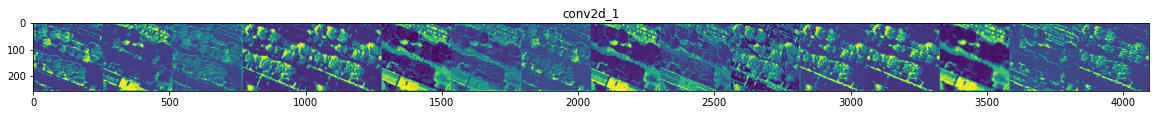

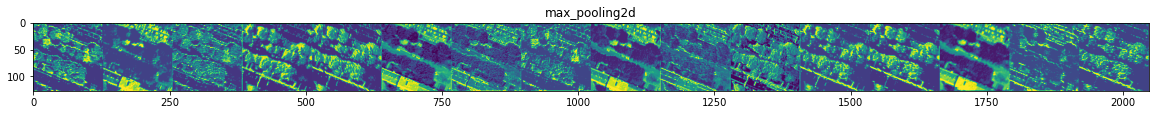

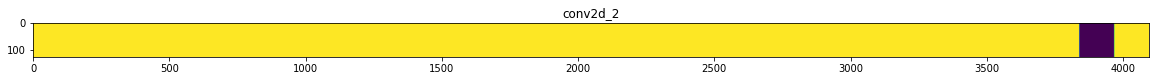

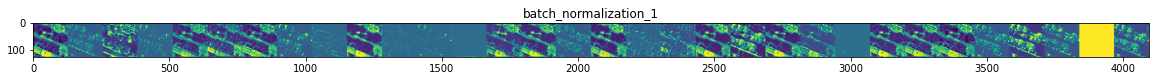

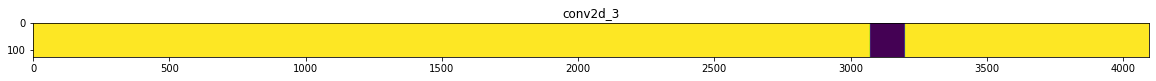

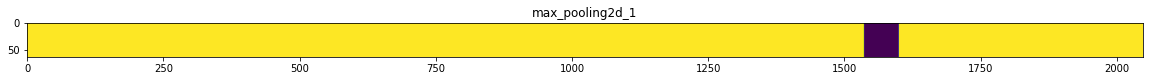

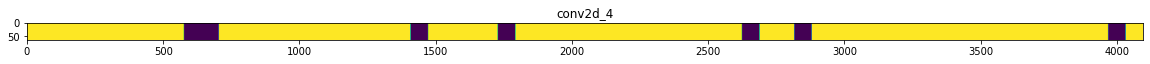

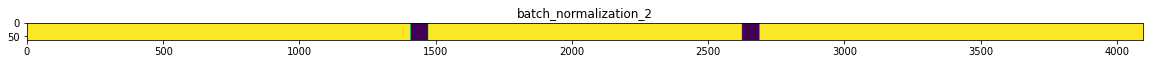

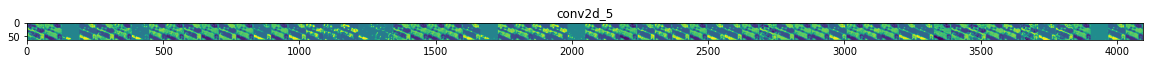

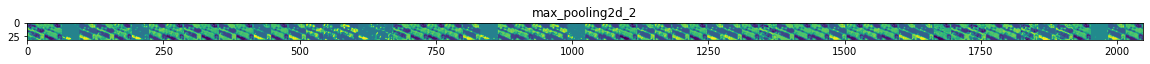

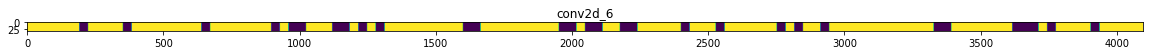

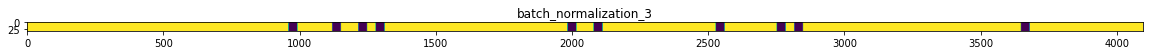

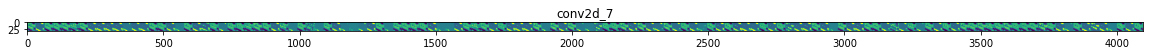

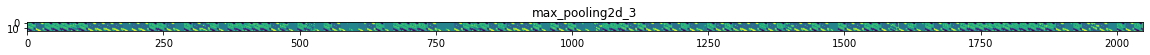

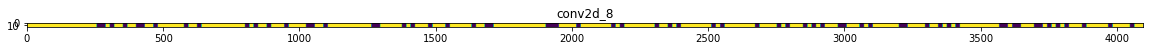

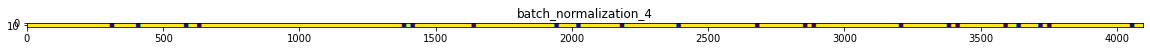

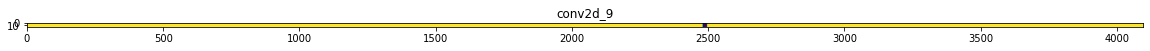

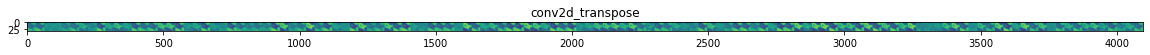

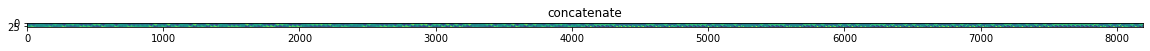

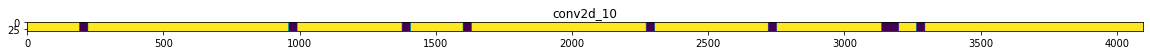

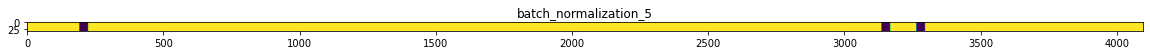

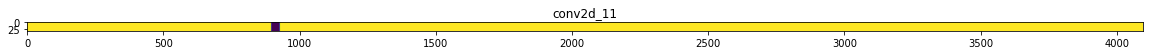

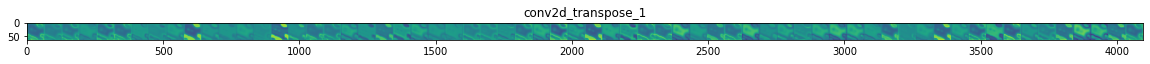

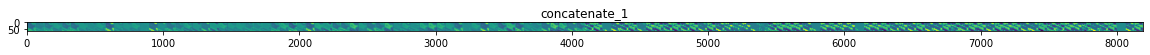

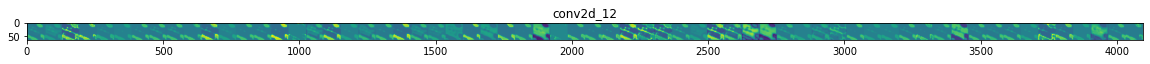

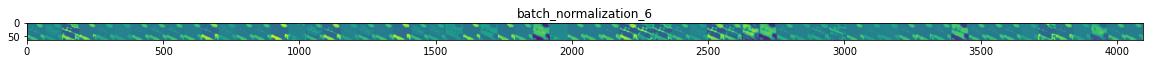

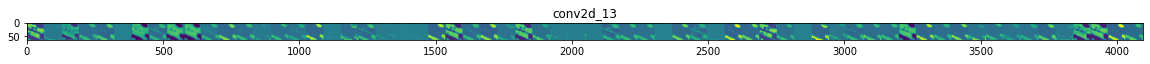

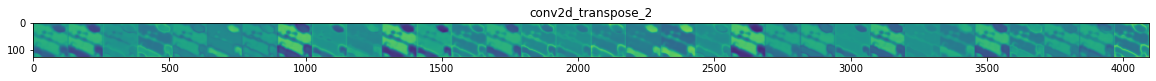

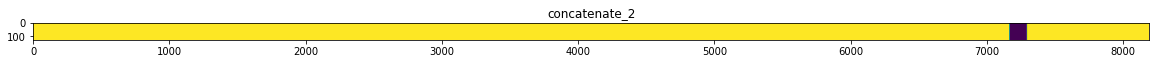

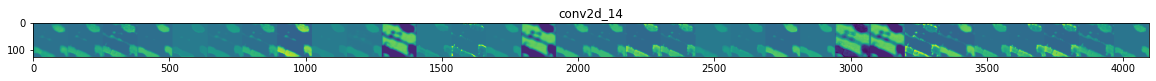

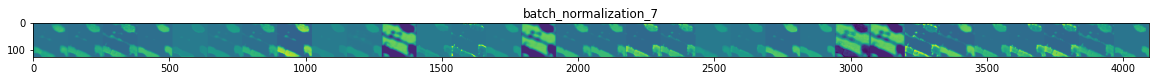

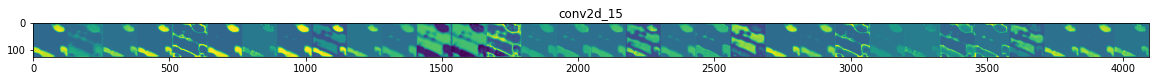

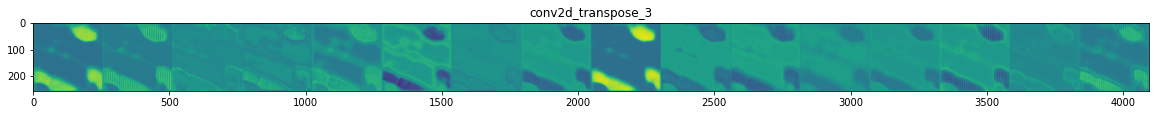

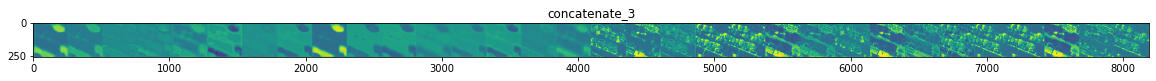

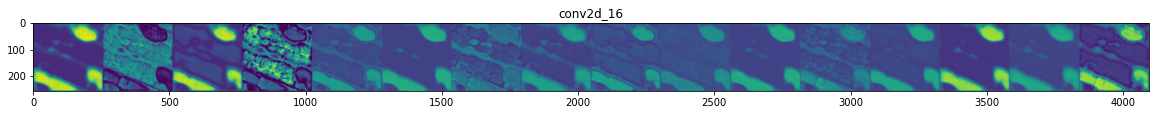

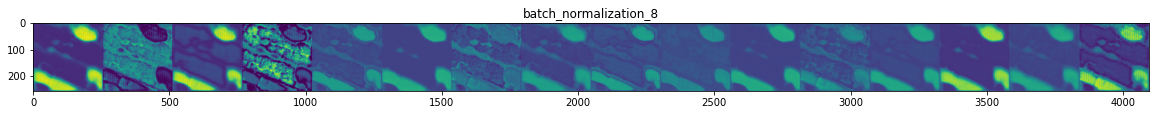

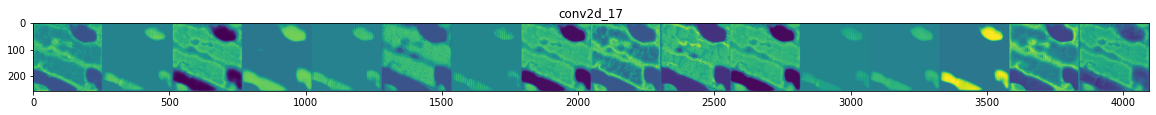

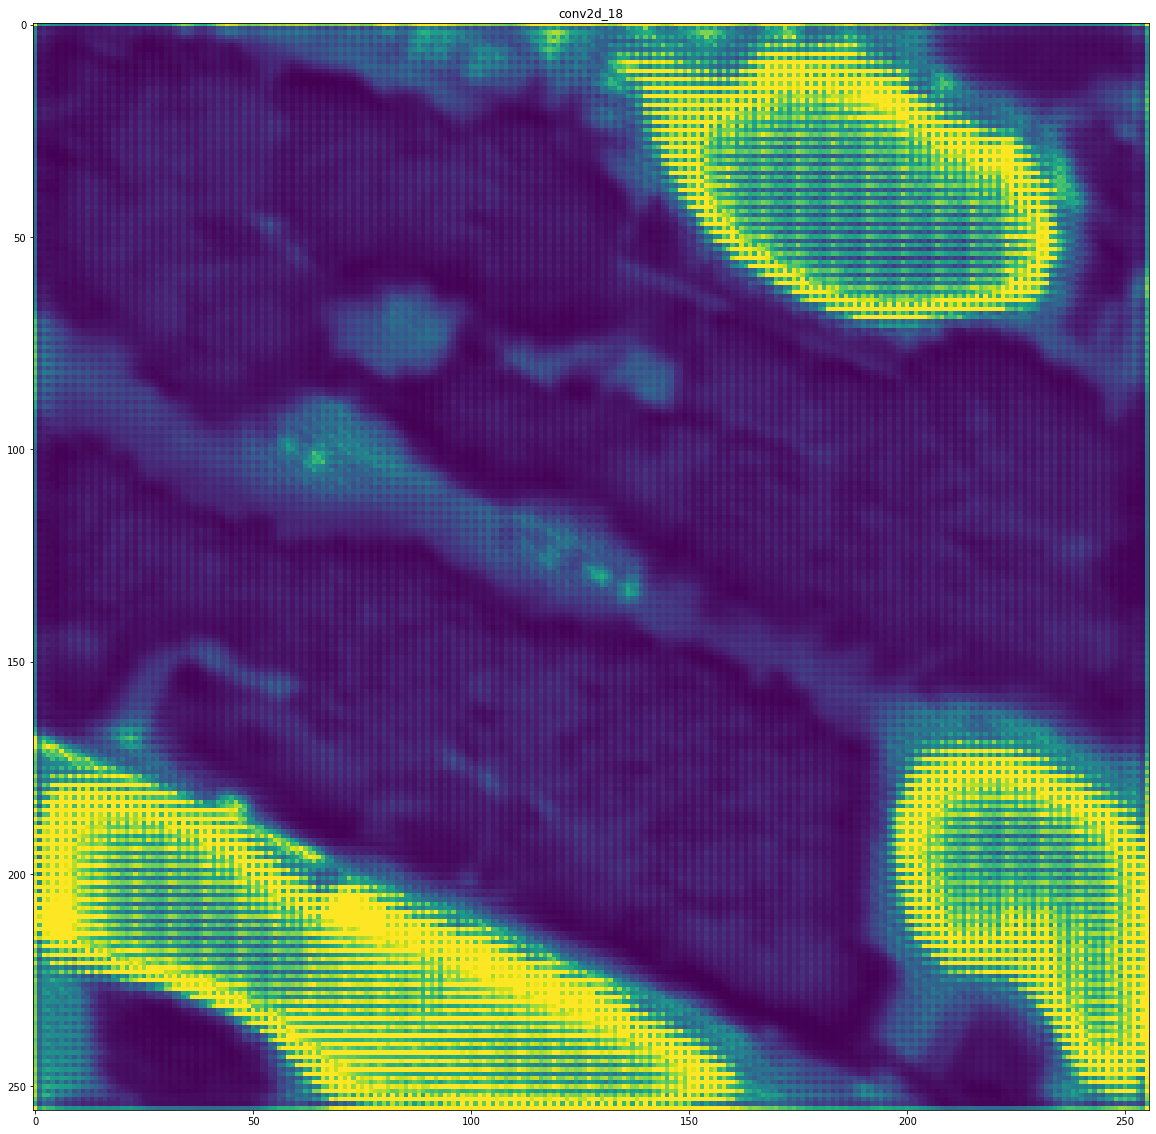

In [19]:
vis_cnn_feature_maps(model, image[0])

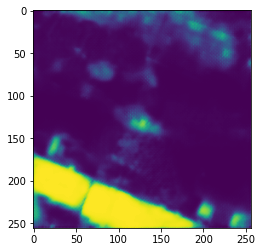

In [27]:
plt.imshow(model.predict(image)[0])